In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
PATH = 'starcraft_player_data.csv'

df = pd.read_csv(PATH)
df.head()

,GameID,LeagueIndex,Age,HoursPerWeek,TotalHours,APM,SelectByHotkeys,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,NumberOfPACs,GapBetweenPACs,ActionLatency,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,ComplexAbilitiesUsed
0,52,5,27,10,3000,143.7180,0.003515,0.000220,7,0.000110,0.000392,0.004849,32.6677,40.8673,4.7508,28,0.001397,6,0.0,0.000000
1,55,5,23,10,5000,129.2322,0.003304,0.000259,4,0.000294,0.000432,0.004307,32.9194,42.3454,4.8434,22,0.001193,5,0.0,0.000208
2,56,4,30,10,200,69.9612,0.001101,0.000336,4,0.000294,0.000461,0.002926,44.6475,75.3548,4.0430,22,0.000745,6,0.0,0.000189
3,57,3,19,20,400,107.6016,0.001034,0.000213,1,0.000053,0.000543,0.003783,29.2203,53.7352,4.9155,19,0.000426,7,0.0,0.000384
4,58,3,32,10,500,122.8908,0.001136,0.000327,2,0.000000,0.001329,0.002368,22.6885,62.0813,9.3740,15,0.001174,4,0.0,0.000019


In [3]:
df.columns

Index(['GameID', 'LeagueIndex', 'Age', 'HoursPerWeek', 'TotalHours', 'APM',
       'SelectByHotkeys', 'AssignToHotkeys', 'UniqueHotkeys', 'MinimapAttacks',
       'MinimapRightClicks', 'NumberOfPACs', 'GapBetweenPACs', 'ActionLatency',
       'ActionsInPAC', 'TotalMapExplored', 'WorkersMade', 'UniqueUnitsMade',
       'ComplexUnitsMade', 'ComplexAbilitiesUsed'],
      dtype='object')

In [4]:
df.count()

GameID                  3395
LeagueIndex             3395
Age                     3395
HoursPerWeek            3395
TotalHours              3395
APM                     3395
SelectByHotkeys         3395
AssignToHotkeys         3395
UniqueHotkeys           3395
MinimapAttacks          3395
MinimapRightClicks      3395
NumberOfPACs            3395
GapBetweenPACs          3395
ActionLatency           3395
ActionsInPAC            3395
TotalMapExplored        3395
WorkersMade             3395
UniqueUnitsMade         3395
ComplexUnitsMade        3395
ComplexAbilitiesUsed    3395
dtype: int64

I first wanted to look for null values. Using the count method, we are able to see that each column has the same number of non-null rows which suggests that there are no null values.

In [5]:
df.dtypes

GameID                    int64
LeagueIndex               int64
Age                      object
HoursPerWeek             object
TotalHours               object
APM                     float64
SelectByHotkeys         float64
AssignToHotkeys         float64
UniqueHotkeys             int64
MinimapAttacks          float64
MinimapRightClicks      float64
NumberOfPACs            float64
GapBetweenPACs          float64
ActionLatency           float64
ActionsInPAC            float64
TotalMapExplored          int64
WorkersMade             float64
UniqueUnitsMade           int64
ComplexUnitsMade        float64
ComplexAbilitiesUsed    float64
dtype: object

But when double checking the dtypes for each column, I noticed that Age, HoursPerWeek, and TotalHours were stores as objects instead of integers like the documentation suggested, so I decided to look into this a little further.

<AxesSubplot:xlabel='Age', ylabel='Count'>

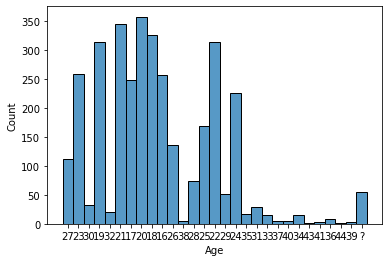

In [6]:
sns.histplot(data=df, x="Age")


In [7]:
df.columns[df.isin(['?']).any()]

Index(['Age', 'HoursPerWeek', 'TotalHours'], dtype='object')

Looking at a histogram for the age column, I noticed that there was a value called ?. And upon further inspection, HoursPerWeek and TotalHours also have this value. So while there are no outright null values, we do still effectively have null values being stored as ?.

In [8]:
missing_df = df[df.eq("?").any(axis=1)]

In [9]:
missing_df.shape

(57, 20)

In [10]:
df.shape

(3395, 20)

In [11]:
df['LeagueIndex'].value_counts()

4    811
5    806
6    621
3    553
2    347
1    167
8     55
7     35
Name: LeagueIndex, dtype: int64

In [12]:
missing_df['LeagueIndex'].value_counts()

8    55
5     2
Name: LeagueIndex, dtype: int64

Normally, you can either delete rows with missing values or impute a new value based on some condition. But in this case, the null values predominantly match to players in group 8, so we would lose alot of information by deleting or imputing. Instead we can set all ? to be a set value i.e. 0 so that the model is able to match any instance of an age = 0 as class 8. 

In practice, it would be good to understand why everyone in group 8 has these missing values before making this change, but since I can't communicate with the data collection team for this project, I choose to make this change.

In [13]:
df = df.replace('?', 0)

In [14]:
df[['Age', 'HoursPerWeek', 'TotalHours']] = df[['Age', 'HoursPerWeek', 'TotalHours']].astype(int)

In [15]:
#Changing classes to be from 0-7 instead of 1-8 as some models need classes to start at 0. i.e XGBoost
df['LeagueIndex'] -= 1

In [16]:
#Dropping ID since it is a unique column
df.drop(columns=['GameID'], inplace = True)

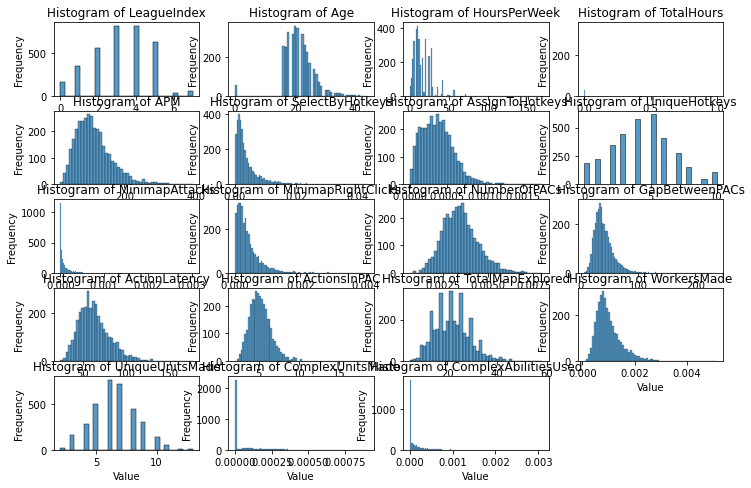

In [17]:
# Calculate the number of rows and columns for subplots
num_rows = (df.shape[1] + 1) // 2  # Round up to the nearest integer
num_cols = 4

# Create subplots with the specified number of rows and columns
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 16))

# Flatten the axes array if necessary
axes = axes.flatten()

# Iterate over each column in the DataFrame
for i, column in enumerate(df.columns):
    # Create a histogram for the current column
    sns.histplot(data=df[column], ax=axes[i])
    
    # Set labels and title for the plot
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Frequency')
    axes[i].set_title('Histogram of {}'.format(column))

# Remove any unused subplots
if len(df.columns) < len(axes):
    for j in range(len(df.columns), len(axes)):
        fig.delaxes(axes[j])


# Display the subplots
plt.show()


<AxesSubplot:>

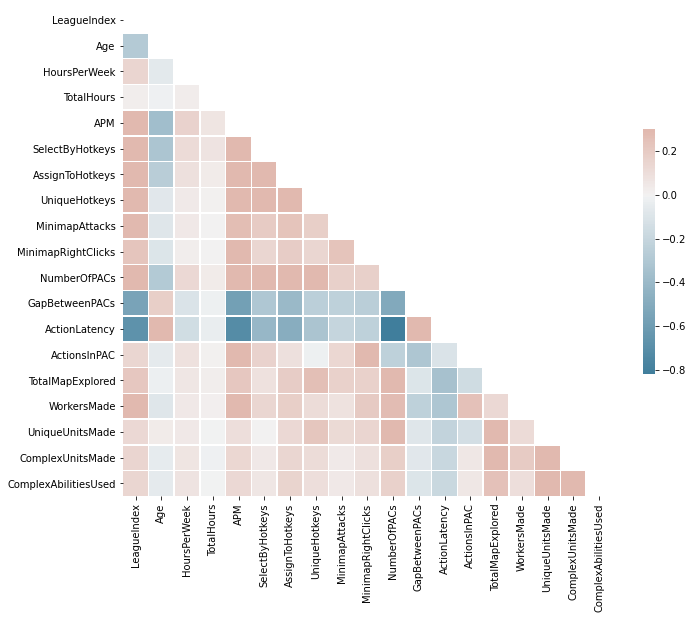

In [18]:
# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

Briefly looking at a correlation plot, we see most columns are vaguely correlated with each other, with the excpection of GapBetweenPACs and Action Latency which have a negative correlation. In particular, there is a strong negative correlation with the LeagueIndex.

Class=4, n=806 (23.741%)
Class=3, n=811 (23.888%)
Class=2, n=553 (16.289%)
Class=1, n=347 (10.221%)
Class=0, n=167 (4.919%)
Class=6, n=35 (1.031%)
Class=5, n=621 (18.292%)
Class=7, n=55 (1.620%)


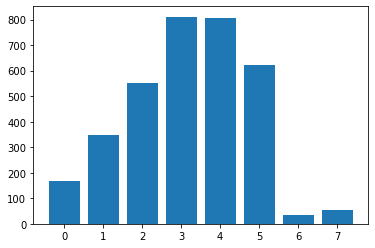

In [19]:
from collections import Counter
counter = Counter(df['LeagueIndex'])
for k,v in counter.items():
    per = v / len(df['LeagueIndex']) * 100
    print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
plt.bar(counter.keys(), counter.values())
plt.show()

The classes are very imbalanced, this will be something we need to consider when building our model.

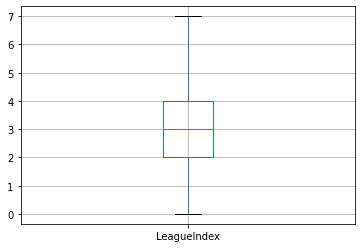

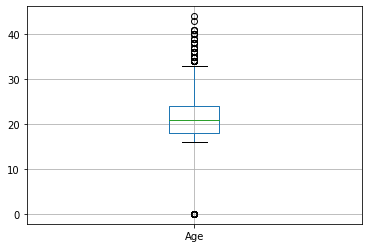

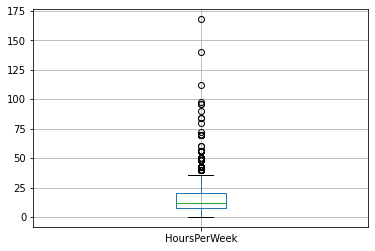

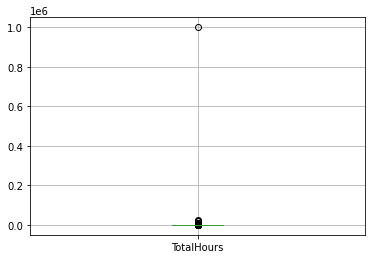

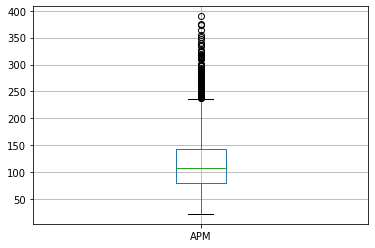

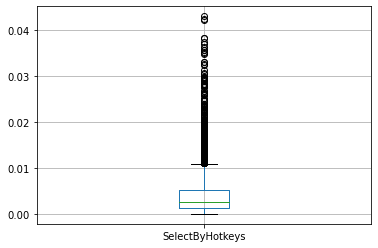

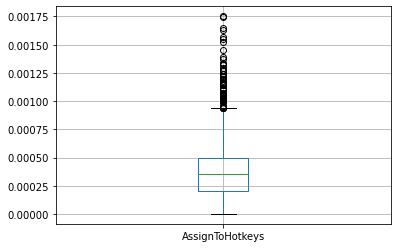

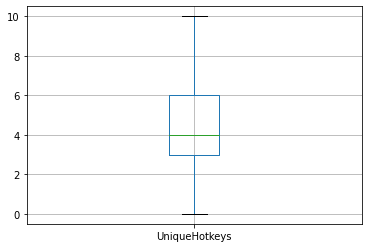

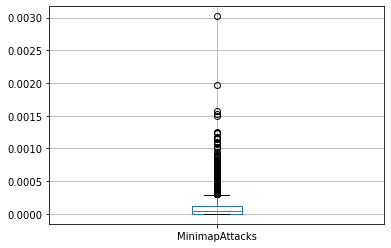

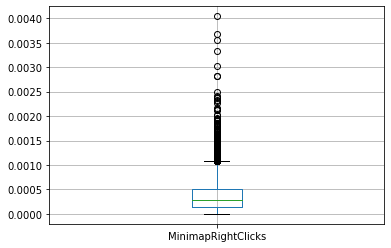

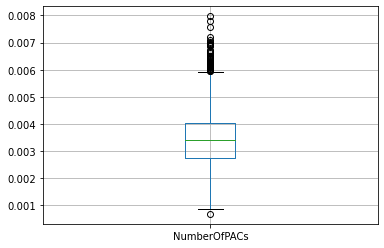

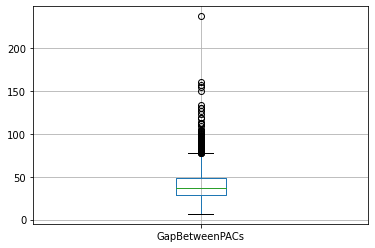

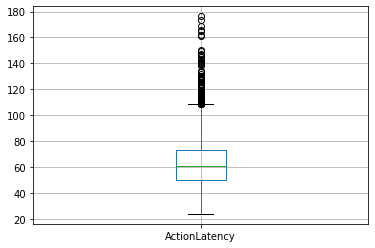

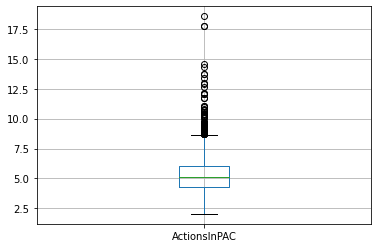

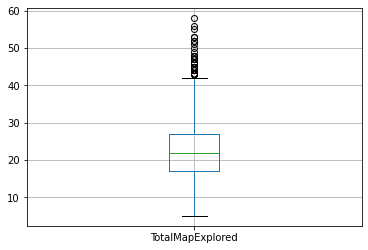

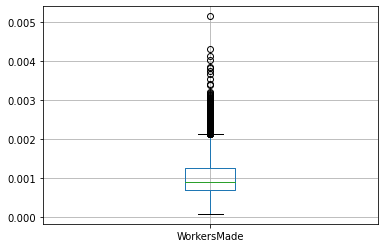

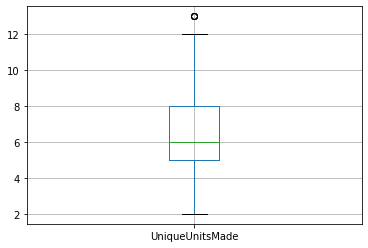

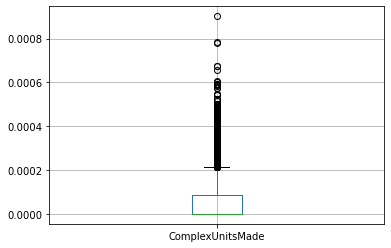

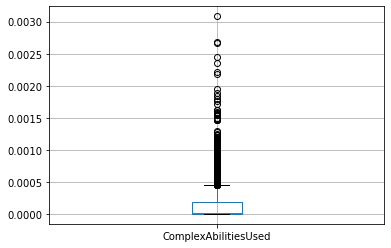

In [20]:
for column in df:
    plt.figure()
    df.boxplot([column])

Looking at a boxplot for each column, totalhours once again stands out as having a problem. There is one outlier that is magnitudes higher than any other value.

In [21]:
df['TotalHours'].quantile(.99)

2520.0

In [22]:
df['TotalHours'].quantile(.99)

2520.0

In [23]:
df[df['TotalHours'] > 5000]


,LeagueIndex,Age,HoursPerWeek,TotalHours,APM,SelectByHotkeys,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,NumberOfPACs,GapBetweenPACs,ActionLatency,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,ComplexAbilitiesUsed
7,6,17,42,10000,212.6022,0.009040,0.000676,6,0.001164,0.001253,0.004952,24.6117,41.7671,6.6104,45,0.002277,9,0.000129,0.000249
10,2,16,16,6000,153.8010,0.001677,0.000319,4,0.000000,0.000822,0.003772,23.4107,48.0711,7.0044,24,0.001593,7,0.000000,0.000017
770,4,22,16,20000,248.0490,0.023703,0.000391,7,0.000000,0.000205,0.004651,37.8795,45.3760,4.7560,21,0.001526,6,0.000000,0.000000
1793,4,18,24,1000000,281.4246,0.023428,0.000799,5,0.000041,0.000447,0.005136,28.1164,36.1266,5.8522,29,0.001328,6,0.000000,0.000000
1978,3,22,10,18000,152.2374,0.011983,0.000206,1,0.000016,0.000364,0.003351,52.1896,63.9811,4.9575,19,0.000680,5,0.000000,0.000000
2140,4,22,10,9000,106.0056,0.003569,0.000635,8,0.000946,0.000575,0.003617,28.6645,55.9603,4.6159,25,0.001018,8,0.000000,0.000156
2216,2,24,20,10260,76.5852,0.000780,0.000197,0,0.000063,0.000316,0.002438,42.9480,84.6340,5.9107,27,0.000450,10,0.000246,0.000358
2324,5,20,8,25000,247.0164,0.015794,0.000438,8,0.000308,0.001339,0.004645,17.6471,37.1837,6.5944,29,0.001860,6,0.000000,0.000012
3253,2,19,20,6000,102.0114,0.002045,0.000317,5,0.000044,0.000555,0.003032,62.5423,67.3140,6.3605,24,0.001410,6,0.000238,0.001948


The user with the totalhours of one million must be an outlier, as they have played too much more than any other player for it to be beliveable. 

In [24]:
df = df[df['TotalHours'] != df['TotalHours'].max()]

<AxesSubplot:>

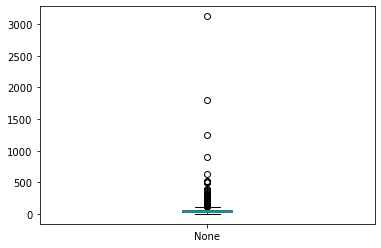

In [25]:
(df['TotalHours']/df['HoursPerWeek']).plot.box()

There are other rows where these values are dubious, but as they are self reported, it is hard to definitely remove them.

In [27]:
df.to_csv('cleaned_starcraft_data.csv', index=False)